# Classification of Covid-19/Pneumonia's X-Rays with VGG16 - Model Build

Dataset - Link

Chest X-Ray Images (Pneumonia) -  https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

COVID-19 chest xray - https://www.kaggle.com/bachrr/covid-chest-xray

COVID-19 Radiography Database - https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

`Import all required Libraries`

In [2]:
!pip install utils

In [3]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shutil
import cv2
import argparse
import os
import random
from imutils import paths
from tensorflow import keras
from keras.layers import AveragePooling2D, Dropout, Dense, Input, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


## Importing Datasets from Kaggle

### Kaggle Importing Setup

In [4]:
# %cd /content/drive/MyDrive/Agastya/

# !pip install -q kaggle

In [5]:
# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

### Chest X-Ray Images (Pneumonia)

In [6]:

# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [7]:
# !ls
# !unzip \*.zip  && rm *.zip

### COVID-19 chest xray

In [8]:
# !kaggle datasets download -d bachrr/covid-chest-xray
# !ls
# !unzip \*.zip  && rm *.zip

### COVID-19 Radiography Database

In [9]:
# !kaggle datasets download -d tawsifurrahman/covid19-radiography-database
# !ls
# !unzip \*.zip  && rm *.zip

# Code Begins ---------

* Setup GPU

In [10]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU Not available")
print("Found GPU at: {}".format(device_name))
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100

Found GPU at: /device:GPU:0


* Set Paths of Datasets

In [11]:
dataset_path = '/content/drive/MyDrive/Agastya/dataset'

In [12]:
%%bash
rm -rf /content/drive/MyDrive/Agastya/dataset
mkdir -p /content/drive/MyDrive/Agastya/dataset/covid
mkdir -p /content/drive/MyDrive/Agastya/dataset/normal
mkdir -p /content/drive/MyDrive/Agastya/dataset/new
mkdir -p /content/drive/MyDrive/Agastya/dataset/pneumonia


In [13]:
covid_path = '/content/drive/MyDrive/Agastya/Input/covid-chest-xray'
pneumonia_path = '/content/drive/MyDrive/Agastya/Input/chest_xray'

* EDA of Covid Dataset (Analysing Datasets)

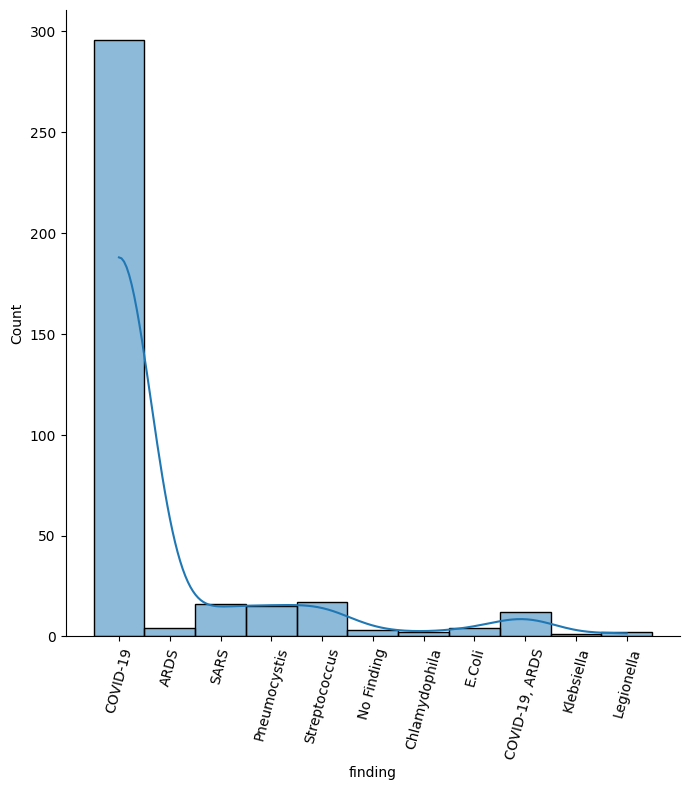

In [14]:
eda = pd.read_csv('/content/drive/MyDrive/Agastya/Input/covid-chest-xray/metadata.csv')
sb.displot(x='finding',data=eda, palette='husl', kde=True, height=7)
# sb.pairplot(data=eda, palette='husl')
plt.xticks(rotation=75)
plt.show()

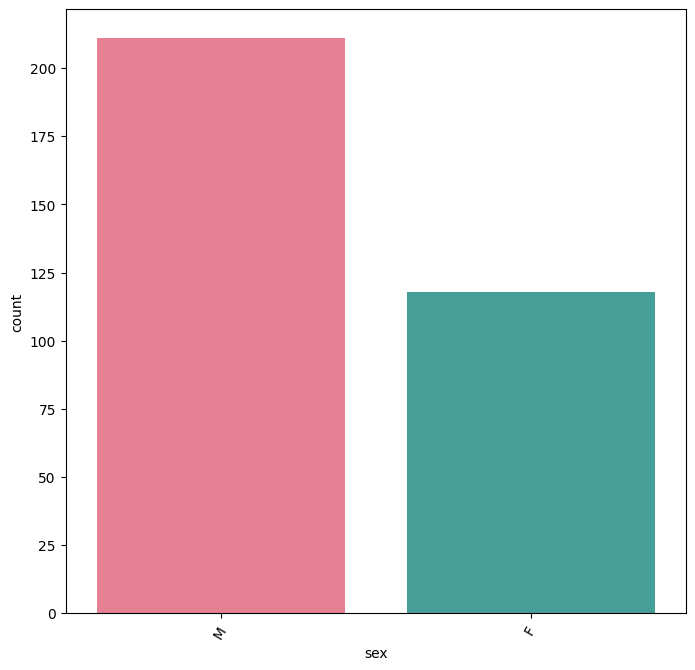

In [15]:
sb.countplot(x = 'sex', data=eda, palette='husl')
plt.xticks(rotation=60)
plt.show()

* ReGenerate new Datasets - from `metadata.csv` file

In [16]:
csv_path = os.path.sep.join([covid_path, "metadata.csv"])
df = pd.read_csv(csv_path)
for (col, row) in df.iterrows():
    if row['finding'] != 'COVID-19' or row['view'] != 'PA': continue
    
    image_path = os.path.sep.join([covid_path, 'images', row['filename']])
    
    if not os.path.exists(image_path): continue
    
    filename = row['filename'].split(os.path.sep)[-1]
    output_path = os.path.sep.join([f'{dataset_path}/covid', filename])    
    shutil.copy2(image_path, output_path)       #copying image


In [17]:
base_path = os.path.sep.join([pneumonia_path, 'train', 'NORMAL'])
image_path2 = list(paths.list_images(base_path))
samples = 146

random.seed(42)
random.shuffle(image_path2)
image_path2 = image_path2[:samples]

for (i, image_path) in enumerate(image_path2):
    filename = image_path.split(os.path.sep)[-1]
    output_path = os.path.sep.join([f'{dataset_path}/normal', filename])
    shutil.copy2(image_path, output_path)

In [18]:
base_path = os.path.sep.join([pneumonia_path, 'train', 'PNEUMONIA'])
image_path2 = list(paths.list_images(base_path))
samples = 146

random.seed(42)
random.shuffle(image_path2)
image_path2 = image_path2[:samples]

for (i, image_path) in enumerate(image_path2):
    filename = image_path.split(os.path.sep)[-1]
    output_path = os.path.sep.join([f'{dataset_path}/pneumonia', filename])
    shutil.copy2(image_path, output_path)

In [19]:
normal_images = list(paths.list_images(f'{dataset_path}/normal'))
covid_images = list(paths.list_images(f'{dataset_path}/covid'))
pneumonia_images = list(paths.list_images(f'{dataset_path}/pneumonia'))
print(*covid_images)
print(*pneumonia_images)
print(*normal_images)

/content/drive/MyDrive/Agastya/dataset/covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg /content/drive/MyDrive/Agastya/dataset/covid/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg /content/drive/MyDrive/Agastya/dataset/covid/auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg /content/drive/MyDrive/Agastya/dataset/covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg /content/drive/MyDrive/Agastya/dataset/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg /content/drive/MyDrive/Agastya/dataset/covid/7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg /content/drive/MyDrive/Agastya/dataset/covid/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg /content/drive/MyDrive/Agastya/dataset/covid/9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg /content/drive/MyDrive/Agastya/dataset/covid/F2DE909F-E19C-4900-92F5-8F435B031AC6.jpeg /content/drive/MyDrive/Agastya/dataset/covid/31BA3780-2323-493F-8AED-62081B9C383B.jpeg /content/drive/MyDr

In [20]:
def ceildiv(a,b):
    return -(-a//b)

def plots_from_files(imspath, figsize=(20,10), rows=1, titles=None, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspath)):
        sp = f.add_subplot(rows, ceildiv(len(imspath), rows), i+1)
        sp.axis('off')
        if titles is not None: 
            sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspath[i])
        # print(-1)
        plt.imshow(img)


* Plot X-Ray in a range

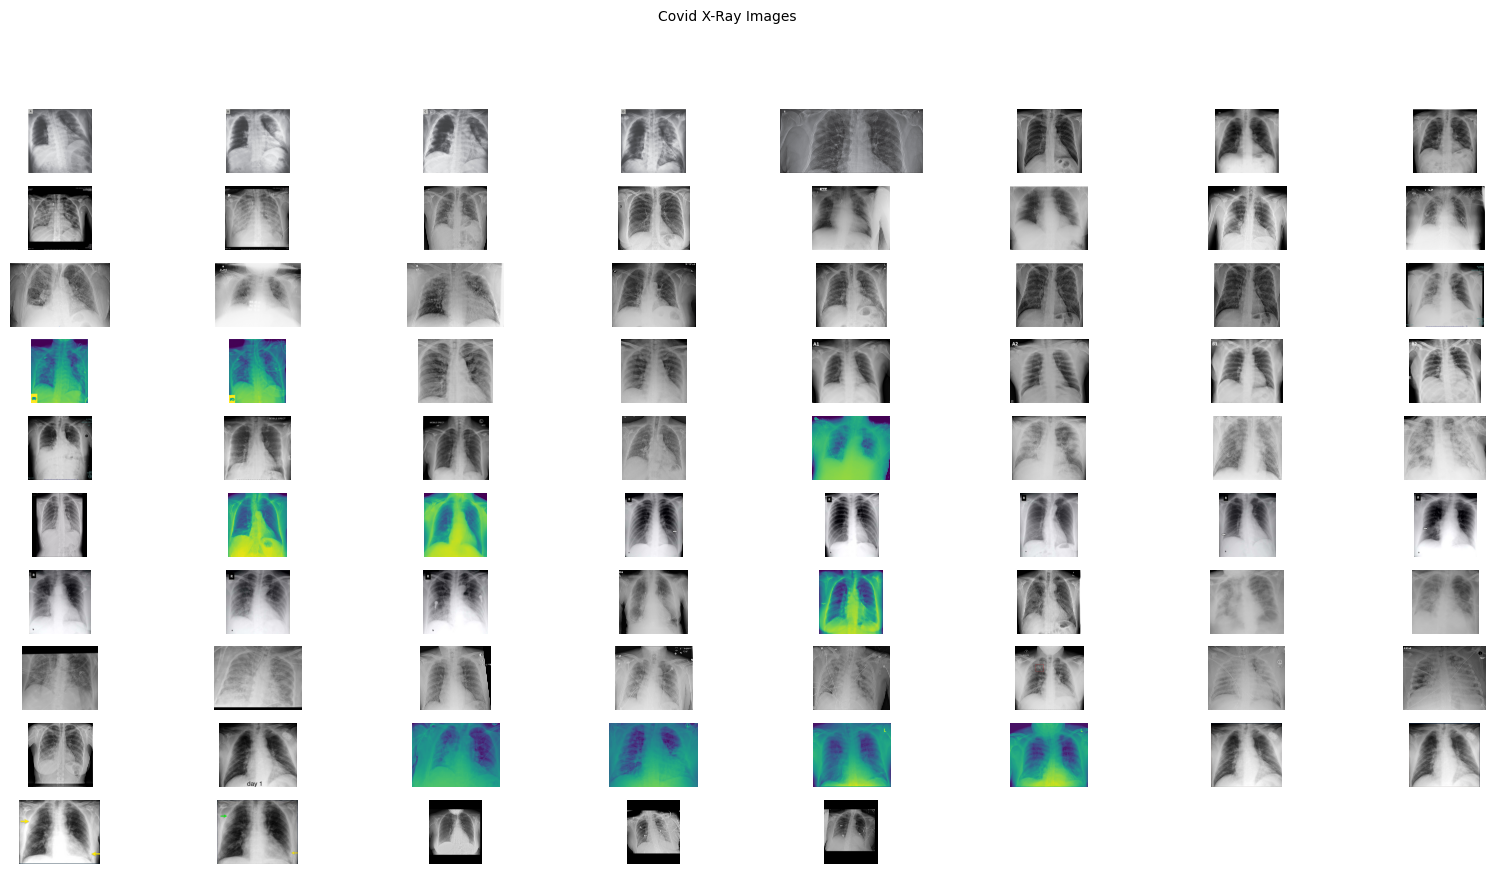

In [21]:
# Covid X-Ray Sheets
plots_from_files(covid_images, rows=10, maintitle='Covid X-Ray Images')

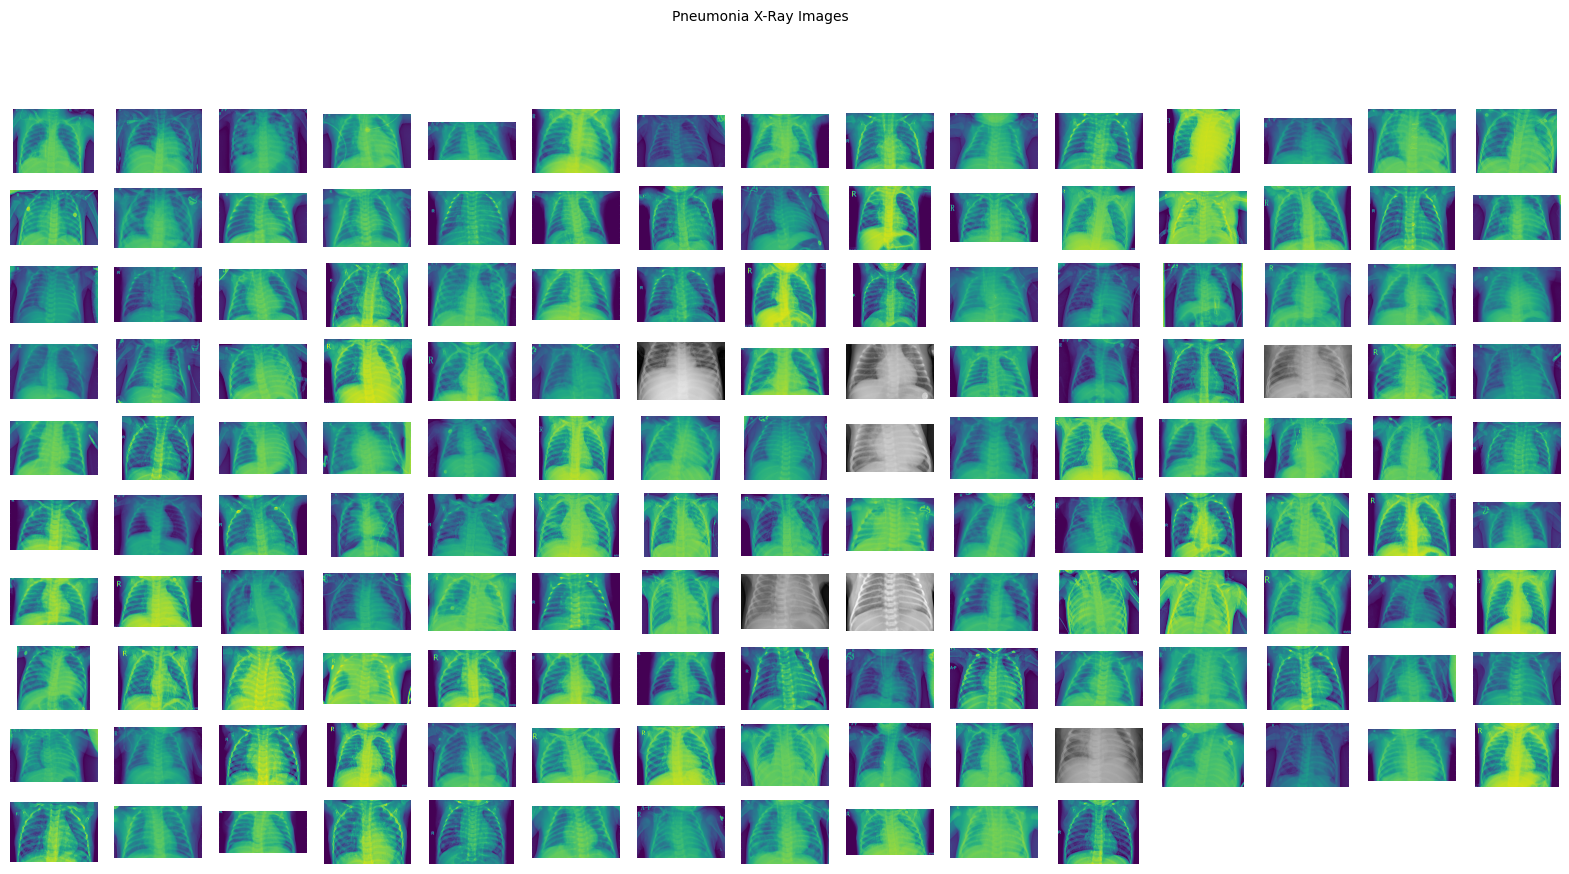

In [22]:
# Pneumonia X-Ray Sheets
plots_from_files(pneumonia_images, rows=10, maintitle='Pneumonia X-Ray Images')

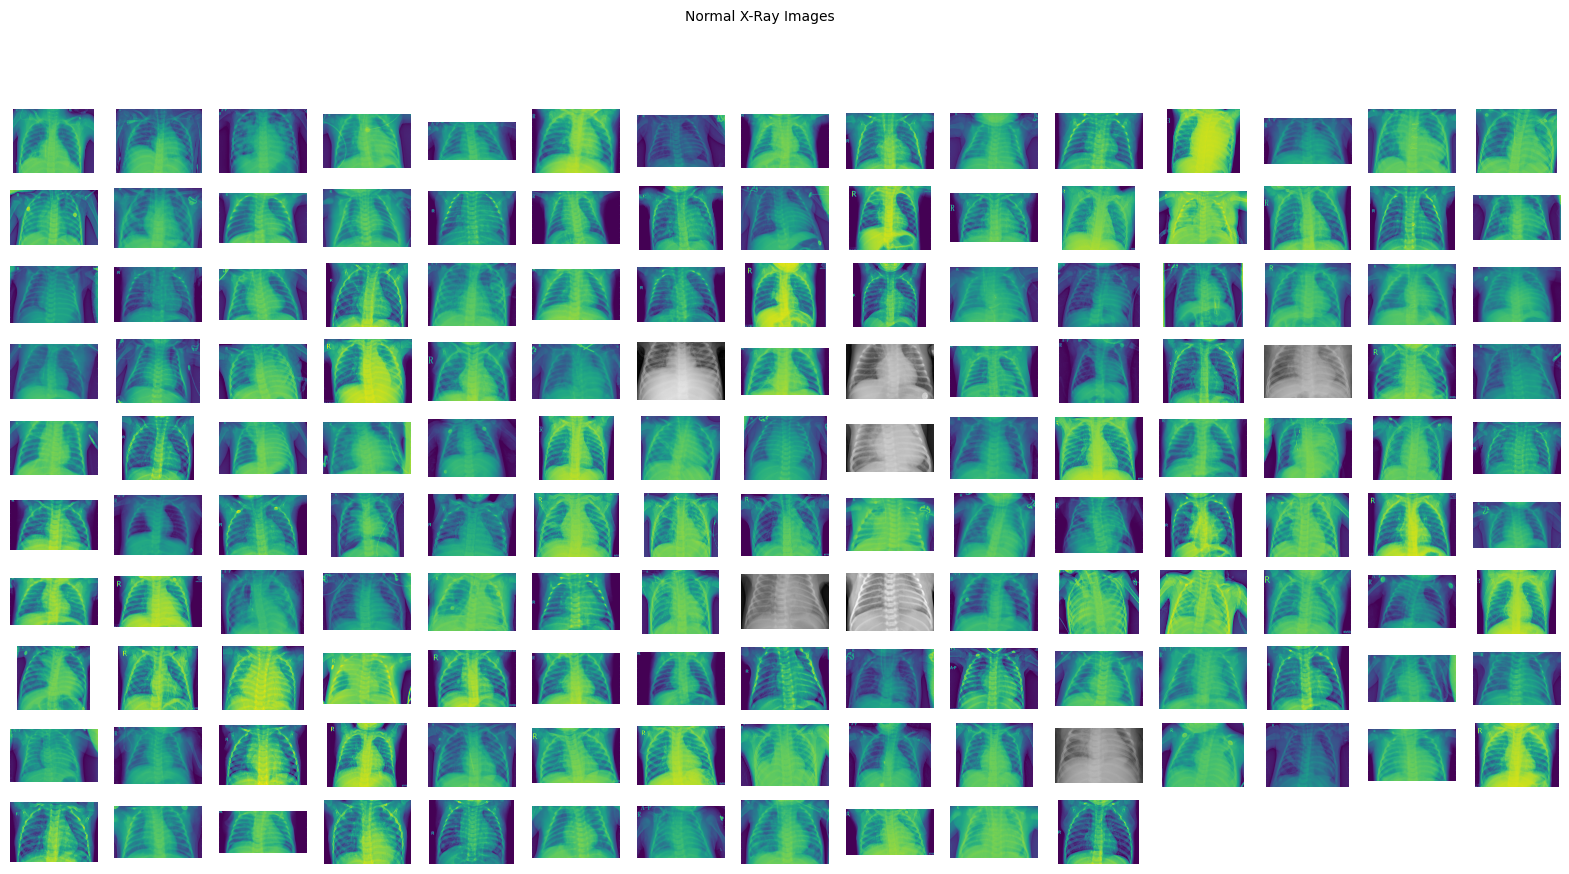

In [23]:
# Normal - XRAY images
plots_from_files(pneumonia_images, rows=10, maintitle='Normal X-Ray Images')

* Data Preprocessing Model deploy work.

In [24]:
INIT_LR = 1e-3
EPOCHS = 140
BS = 8

In [25]:
print("Loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)
print("Images loaded successfully ")

Loading images...
Images loaded successfully 


In [26]:
lb_encoder = LabelEncoder()
labels = lb_encoder.fit_transform(labels)
labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify = labels, random_state = 42)
trainAugmentation = ImageDataGenerator(rotation_range=15, fill_mode='nearest')

* Modeling with VGG16 model

In [27]:
# base_model = VGG16(weights='imagenet', 
#                 include_top = False, 
#                 input_tensor=Input(shape=(224, 224, 3)))
base_model = VGG16(weights='imagenet', 
                include_top = False, 
                input_tensor=Input(shape=(224, 224, 3)))
headmodel = base_model.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name = 'Flatten')(headmodel)
headmodel = Dense(64, activation = 'relu')(headmodel)
headmodel = Dropout(0.5)(headmodel)
headmodel = Dense(3, activation = 'softmax')(headmodel)
model = Model(inputs = base_model.input, outputs = headmodel)

for layers in base_model.layers:
    layers.trainable = False

opt = Adam(lr = INIT_LR, decay = INIT_LR/EPOCHS)
model.compile(loss = 'binary_crossentropy', 
              optimizer = opt,
              metrics = ['accuracy'])


58900480/58889256 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [28]:
model.summary()                                      

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
with tf.device('/gpu:0'):
    print("Training the model with GPU..")
    training = model.fit_generator(trainAugmentation.flow(X_train,
                                                          y_train, 
                                                          batch_size = BS),
                                   steps_per_epoch = len(X_train)//BS,
                                   validation_data = (X_test,
                                                      y_test),
                                   validation_steps = len(X_test)//BS,
                                   epochs = 140)
model.save('trained_Model.hdf5')

Training the model with GPU..


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/140
36/36 [==============================] - 53s 258ms/step - loss: 0.6432 - accuracy: 0.4323 - val_loss: 0.5750 - val_accuracy: 0.6486
Epoch 2/140
36/36 [==============================] - 3s 93ms/step - loss: 0.5988 - accuracy: 0.4887 - val_loss: 0.5380 - val_accuracy: 0.6351
Epoch 3/140
36/36 [==============================] - 3s 92ms/step - loss: 0.5474 - accuracy: 0.5971 - val_loss: 0.5028 - val_accuracy: 0.6216
Epoch 4/140
36/36 [==============================] - 3s 93ms/step - loss: 0.5430 - accuracy: 0.6098 - val_loss: 0.4660 - val_accuracy: 0.7568
Epoch 5/140
36/36 [==============================] - 3s 94ms/step - loss: 0.4793 - accuracy: 0.7045 - val_loss: 0.4309 - val_accuracy: 0.7703
Epoch 6/140
36/36 [==============================] - 3s 95ms/step - loss: 0.4486 - accuracy: 0.7190 - val_loss: 0.4146 - val_accuracy: 0.7973
Epoch 7/140
36/36 [==============================] - 3s 93ms/step - loss: 0.4466 - accuracy: 0.7178 - val_loss: 0.3807 - val_accuracy: 0.8243
Epoc

* Evaluation

In [30]:
model.load_weights('trained_Model.hdf5')

In [31]:
test_results = {}

test_results['accuracy'] = model.evaluate(
    data, labels, verbose=0)

print(f" Accuracy: {test_results['accuracy']}")


 Accuracy: [0.05198601260781288, 0.9810298085212708]


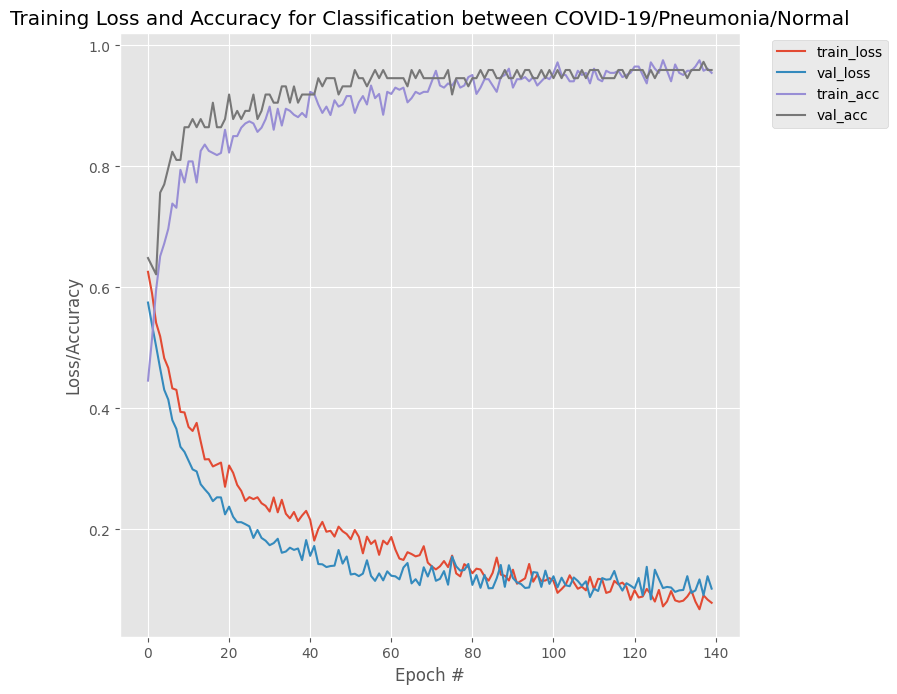

In [32]:
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), training.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), training.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), training.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), training.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy for Classification between COVID-19/Pneumonia/Normal")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot.png")

In [33]:
print('  '*10,"EVALUAITON OF NETWORK DATA")
predIdxs = model.predict(X_test, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(y_test.argmax(axis=1), predIdxs, target_names=lb_encoder.classes_))

                     EVALUAITON OF NETWORK DATA
              precision    recall  f1-score   support

       covid       0.94      1.00      0.97        16
      normal       0.94      1.00      0.97        29
   pneumonia       1.00      0.90      0.95        29

    accuracy                           0.96        74
   macro avg       0.96      0.97      0.96        74
weighted avg       0.96      0.96      0.96        74



In [34]:
cm = confusion_matrix(y_test.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print("accuracy     : {:.4f} %".format(acc*100))
print("sensitivity  : {:.4f}".format(sensitivity))
print("specificity  : {:.4f}".format(specificity))

accuracy     : 60.8108 %
sensitivity  : 1.0000
specificity  : 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

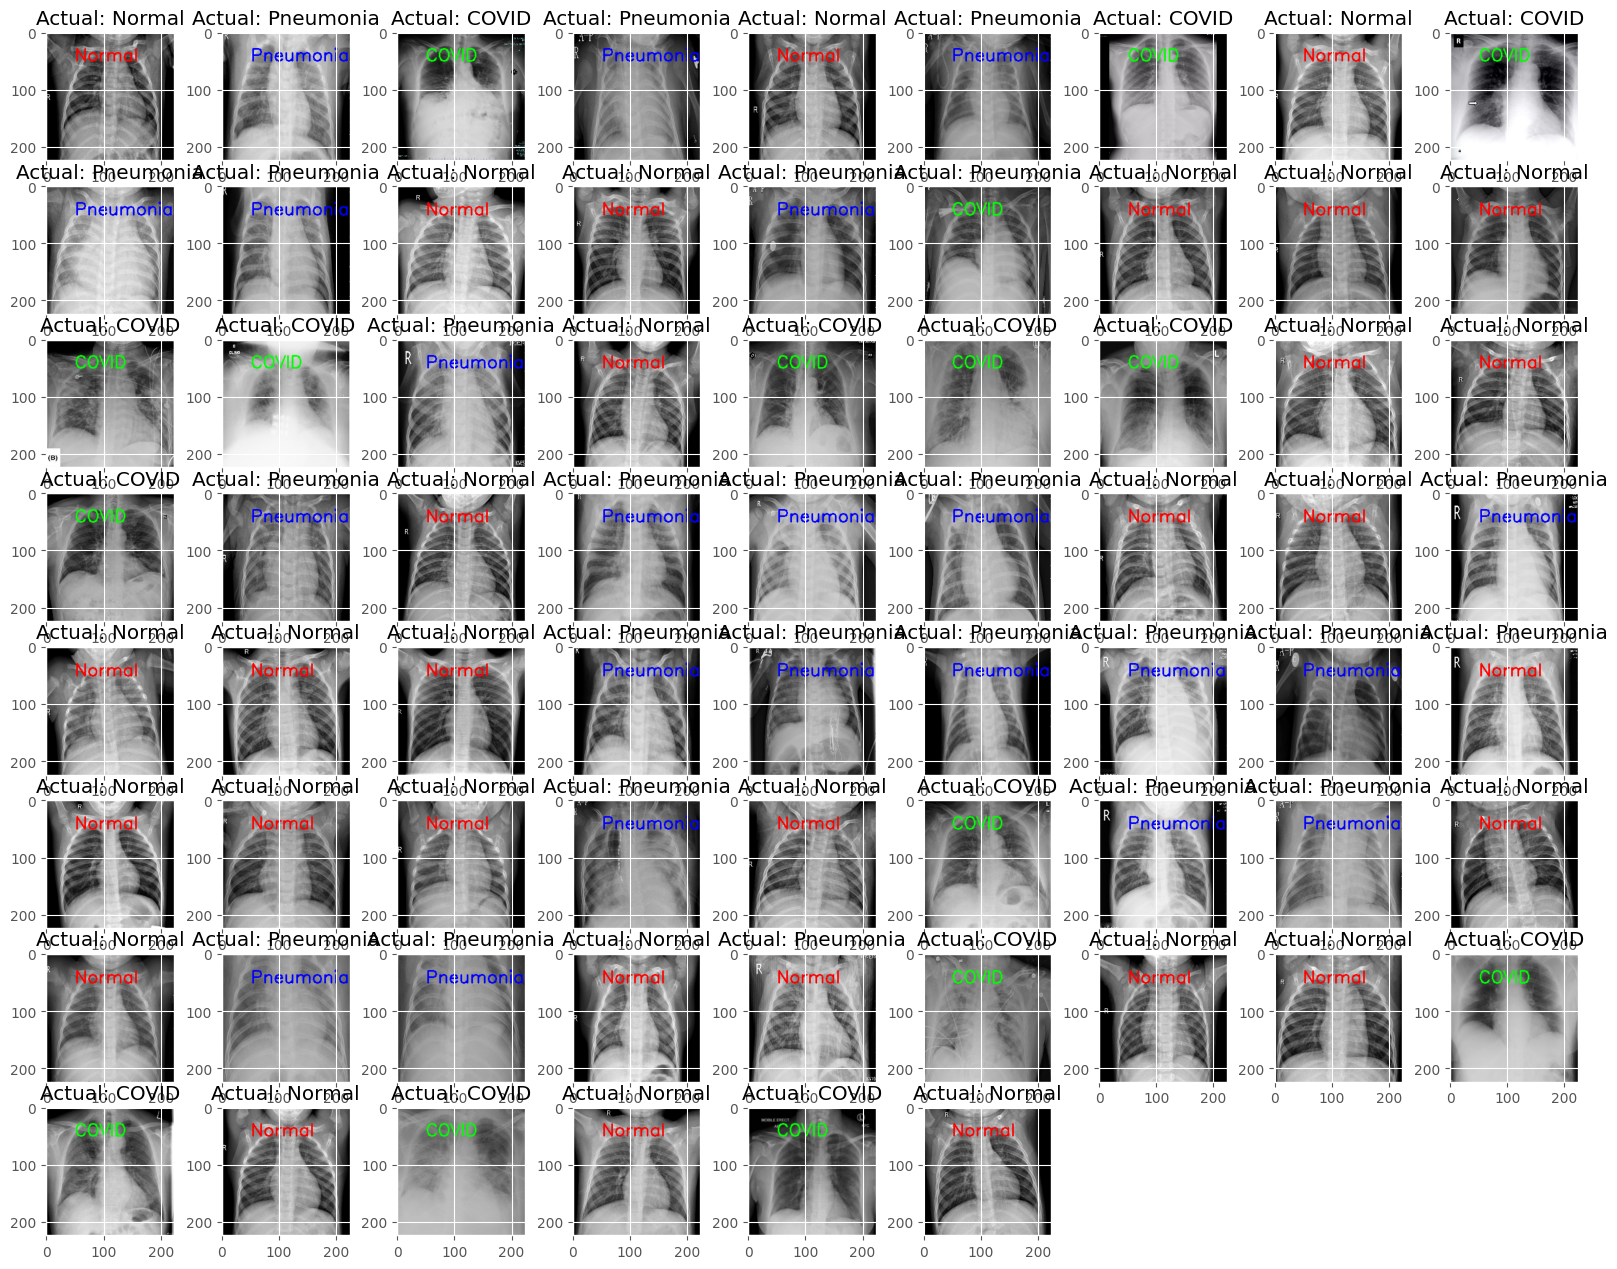

In [35]:
rows = 10
columns = 9
fig = plt.figure(figsize=(20,20))
for m in range(1, 70):
    if str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "covid":
        text = "COVID"
        color = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(predIdxs)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
        
    if str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "covid":
        text2 = "COVID"
        color2 = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "normal":
        text2 = "Normal"
        color2 = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(y_test.argmax(axis=1))[m-1]) == "pneumonia":
        text2 = "Pneumonia"
        color2 = (0, 0, 255)
    img = X_test[m-1].copy()
    window_name = text
   
    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (50, 50) 
  
    fontScale = 1  
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.title("Actual: " + text2)
    plt.axis('on')
plt.show()

# Data Testing ------------- NEED TO SPLIT THIS PART, WORK AS SINGLE MODULE-------------

In [36]:
new_dt = '/content/drive/MyDrive/Agastya/Input/COVID-19_Radiography_Dataset'
# model = load_model('/content/drive/MyDrive/Agastya/trained_Model.h5')

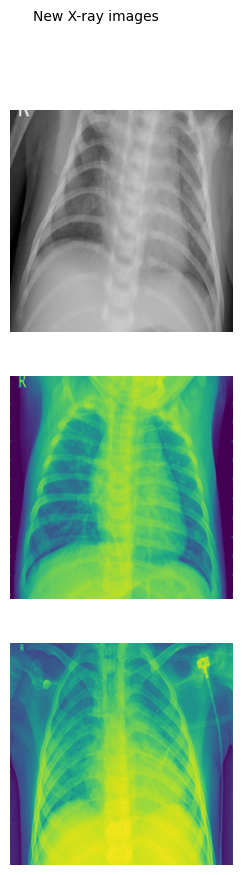

In [37]:
basePath = os.path.sep.join([new_dt, "Viral Pneumonia"])
imagePaths = list(paths.list_images(basePath))
samples = 3
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]
for (i, imagePath) in enumerate(imagePaths):

    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/new", filename])
    shutil.copy2(imagePath, outputPath)

new_images = list(paths.list_images(f"{dataset_path}/new"))
plots_from_files(new_images, rows=3, maintitle="New X-ray images")

In [38]:
new_data = []
for imagePath in imagePaths:
    new_image = cv2.imread(imagePath)
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    new_image = cv2.resize(new_image, (224, 224))
    new_data.append(new_image)

new_data = np.array(new_data) / 255.0
new_data

array([[[[0.16470588, 0.16470588, 0.16470588],
         [0.18039216, 0.18039216, 0.18039216],
         [0.19215686, 0.19215686, 0.19215686],
         ...,
         [0.32156863, 0.32156863, 0.32156863],
         [0.28627451, 0.28627451, 0.28627451],
         [0.2745098 , 0.2745098 , 0.2745098 ]],

        [[0.16862745, 0.16862745, 0.16862745],
         [0.18823529, 0.18823529, 0.18823529],
         [0.19607843, 0.19607843, 0.19607843],
         ...,
         [0.33333333, 0.33333333, 0.33333333],
         [0.29019608, 0.29019608, 0.29019608],
         [0.2745098 , 0.2745098 , 0.2745098 ]],

        [[0.18039216, 0.18039216, 0.18039216],
         [0.19607843, 0.19607843, 0.19607843],
         [0.2       , 0.2       , 0.2       ],
         ...,
         [0.33333333, 0.33333333, 0.33333333],
         [0.30196078, 0.30196078, 0.30196078],
         [0.28235294, 0.28235294, 0.28235294]],

        ...,

        [[0.21568627, 0.21568627, 0.21568627],
         [0.24705882, 0.24705882, 0.24705882]

In [39]:
# make new predictions:
print("[INFO] Making new predictions...")
new_pred = model.predict(new_data, batch_size=8)
new_pred = np.argmax(new_pred, axis=1)
print("[INFO] New Prediction Complete")


[INFO] Making new predictions...
[INFO] New Prediction Complete


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] printing new images with their classification


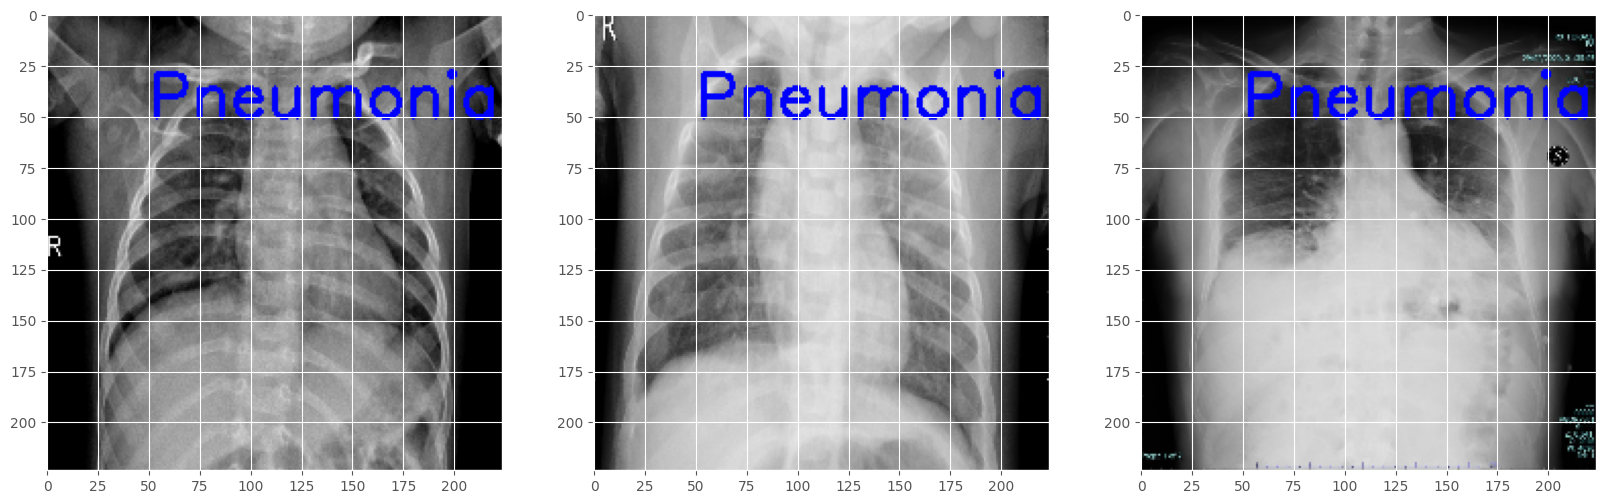

In [40]:
print("[INFO] printing new images with their classification")
rows = 1
columns = 3
fig = plt.figure(figsize=(20, 20))
for m in range(1, 4):
    if str(lb_encoder.inverse_transform(new_pred)[m-1]) == "covid":
        text = "COVID"
        color = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(new_pred)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(new_pred)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
    img = X_test[m-1].copy()
    window_name = text
  
    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (50, 50) 
    fontScale = 1

    thickness = 2
    img = cv2.putText(img, text,
                      org, font,
                      fontScale, color,
                      thickness, cv2.LINE_AA)
    
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.axis('on')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[INFO] Making new prediction...
[INFO] printing new image with its classification
------- pneumonia


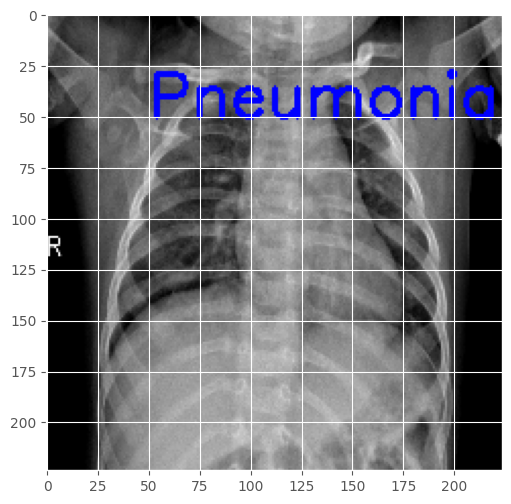

In [60]:
new_data2 = []

new_imag2 = cv2.imread('/content/drive/MyDrive/Agastya/dataset/pneumonia/person1634_bacteria_4334.jpeg')
new_imag2 = cv2.cvtColor(new_imag2, cv2.COLOR_BGR2RGB)
new_imag2 = cv2.resize(new_imag2, (224,224))
new_data2.append(new_imag2)

new_data2 = np.array(new_data2)/255.0
print("[INFO] Making new prediction...")
new_pred2 = model.predict(new_data2, batch_size=BS)
new_pred2 = np.argmax(new_pred2, axis=1)
print("[INFO] printing new image with its classification")
rows = 1
columns = 3
fig = plt.figure(figsize=(20, 20))
for m in range(1, 2):
    print("-------",str(lb_encoder.inverse_transform(new_pred2)[m-1]))
    if str(lb_encoder.inverse_transform(new_pred2)[m-1]) == "covid":
        text = "COVID"
        color = (0, 255, 0)
    elif str(lb_encoder.inverse_transform(new_pred2)[m-1]) == "normal":
        text = "Normal"
        color = (255, 0, 0)
    elif str(lb_encoder.inverse_transform(new_pred2)[m-1]) == "pneumonia":
        text = "Pneumonia"
        color = (0, 0, 255)
    img = X_test[m-1].copy()
    window_name = text
    font = cv2.FONT_HERSHEY_SIMPLEX 
    org = (50, 50) 
    fontScale = 1
    thickness = 2
    img = cv2.putText(img, text, org, font,
                      fontScale, color, thickness, cv2.LINE_AA)
    fig.add_subplot(rows, columns, m)
    plt.imshow(img)
    plt.axis('on')
plt.show()



* References
* https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/
* https://assets.researchsquare.com/files/rs-34534/v1_stamped.pdf
* https://www.sciencedirect.com/science/article/pii/S2352914820305554
* https://medium.com/saturdays-ai/detector-de-covid-19-usando-im%C3%A1genes-de-rayos-x-eaa146efa26
* https://www.kaggle.com/bachrr/detecting-covid-19-in-x-ray-images-with-tensorflow?select=images


In [51]:
import base64
import io
from PIL import Image
from keras.models import load_model, Model
import cv2

In [52]:
def preprocess(img):
    img = np.array(img)
    img = np.full((100,80,3), 12, np.uint8)
    # if img.ndim == 4:
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # else:
    gray = img
    gray = gray/255
    resized = cv2.resize(gray, (224, 224))
    gray = np.expand_dims(gray, axis=0)
    reshaped = resized.reshape(1, 224, 224, 3)
    return reshaped

In [54]:
byteImgIO = io.BytesIO()
img_path = "/content/drive/MyDrive/Agastya/dataset/pneumonia/person1634_bacteria_4334.jpeg"
byteImg = Image.open(img_path)
byteImg.save(byteImgIO, "PNG")
byteImgIO.seek(0)
byteImg = byteImgIO.read()
dataBytesIO = io.BytesIO(byteImg)
image = Image.open(dataBytesIO)

test_image = preprocess(image)
prediction = model.predict(test_image)
result = np.argmax(prediction, axis=1)[0]
accuracy = float(np.max(prediction, axis=1)[0])

# print(prediction, result, accuracy)
if result == 0:
    print("{} \n {:.2f}".format(result, accuracy))
else:
    print("{} \n {:.2f}".format(result, accuracy))


0 
 1.00
